<a href="https://colab.research.google.com/github/WesleyAldridge/VGG19-Heatmaps/blob/master/VGG19_Heatmaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## In this notebook:
- I use Keras Deep Learning Library to import VGG19 and set up an instance of the Convolutional Neural Network.
- I write a function to generate heatmaps of the class activations of the CNN and another function to overlay these heatmaps onto the input images using Matplotlib and CV2's Computer Vision library.
- I test the functions on images of cats and dogs from the web.
- These heatmaps provide a visual aid to better understand what features VGG19 uses to perform its classifications.

### * Scroll to bottom of the notebook to see the images

## Imports

In [0]:
import cv2
from google.colab.patches import cv2_imshow

from google.colab import files

from keras import models, layers, optimizers
from keras import backend as K
from keras.models import Model
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input, decode_predictions
from keras.models import load_model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from matplotlib import pyplot as plt

import numpy as np

import os

import zipfile

## Retrieving cat and dog images from web

In [0]:
!wget https://i.imgur.com/B8q40fP.jpg -O cat1.jpg
!wget https://i.imgur.com/4FJfy8m.jpg -O cat2.jpg
!wget https://i.imgur.com/1nrXWnW.jpg -O dog1.jpg
!wget https://i.imgur.com/nDje2MV.jpg -O dog2.jpg
  
img_path1 = 'cat1.jpg'
img_path2 = 'cat2.jpg'
img_path3 = 'dog1.jpg'
img_path4 = 'dog2.jpg'

--2019-04-18 03:50:03--  https://i.imgur.com/B8q40fP.jpg
Resolving i.imgur.com (i.imgur.com)... 151.101.248.193
Connecting to i.imgur.com (i.imgur.com)|151.101.248.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 370852 (362K) [image/jpeg]
Saving to: ‘cat1.jpg’

cat1.jpg            100%[===================>] 362.16K  --.-KB/s    in 0.05s   

2019-04-18 03:50:03 (7.05 MB/s) - ‘cat1.jpg’ saved [370852/370852]

--2019-04-18 03:50:04--  https://i.imgur.com/4FJfy8m.jpg
Resolving i.imgur.com (i.imgur.com)... 151.101.248.193
Connecting to i.imgur.com (i.imgur.com)|151.101.248.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 352094 (344K) [image/jpeg]
Saving to: ‘cat2.jpg’

cat2.jpg            100%[===================>] 343.84K  --.-KB/s    in 0.05s   

2019-04-18 03:50:04 (6.70 MB/s) - ‘cat2.jpg’ saved [352094/352094]

--2019-04-18 03:50:04--  https://i.imgur.com/1nrXWnW.jpg
Resolving i.imgur.com (i.imgur.com)... 151.101.248.193
Connec

## Setting up an instance of VGG19

In [0]:
model = VGG19(weights='imagenet')

model.summary()

last_conv_layer = model.get_layer('block5_conv4')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Creating the functions to generate heatmaps and overlay them onto the images

In [0]:
def show_superimposed_image(img_path, heatmap):
  img = cv2.imread(img_path)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = heatmap * 0.4 + img
  cv2_imshow(superimposed_img)
  

def process_image(img_path, idx=0):
  img = image.load_img(img_path, target_size=(224, 224))
  
  plt.imshow(img)
  plt.grid(False)
  plt.show()
  
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  
  preds = model.predict(x)
  print('Predicted:', decode_predictions(preds, top=2)[0])
  
  class_index = np.argsort(preds[0])[-(1+idx)]
  class_output = model.output[:, class_index]
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis=-1)
  
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  plt.matshow(heatmap)
  plt.grid(False)
  plt.show()
  
  show_superimposed_image(img_path, heatmap)

## Calling the functions on example images found on the web

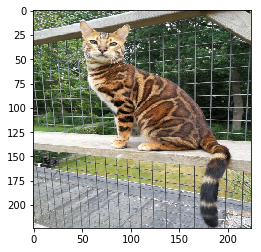

Predicted: [('n02123159', 'tiger_cat', 0.7528311), ('n02123045', 'tabby', 0.22409303)]


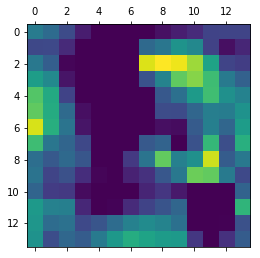

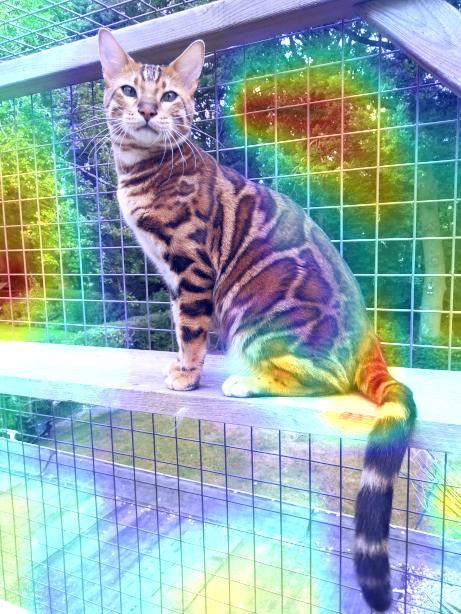

In [0]:
process_image(img_path1)

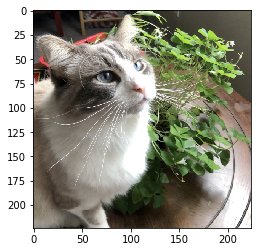

Predicted: [('n02123597', 'Siamese_cat', 0.37967652), ('n02124075', 'Egyptian_cat', 0.28091493)]


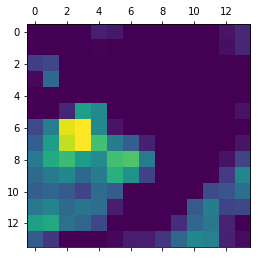

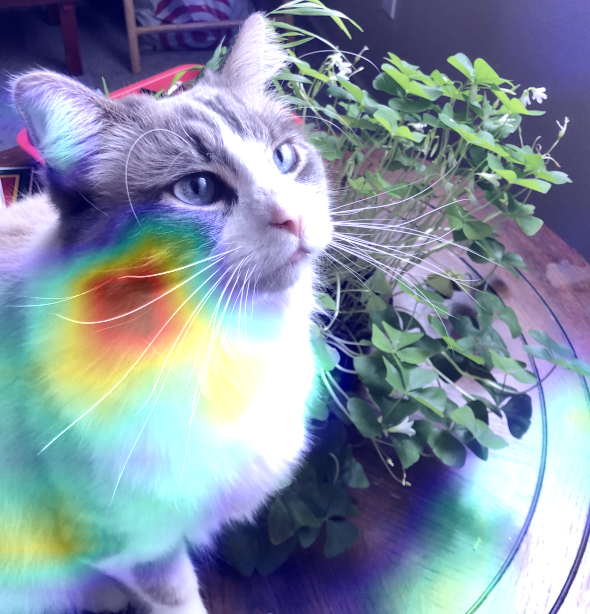

In [0]:
process_image(img_path2)

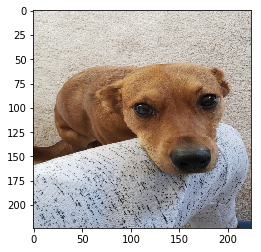

Predicted: [('n02107312', 'miniature_pinscher', 0.22141336), ('n02087394', 'Rhodesian_ridgeback', 0.15780027)]


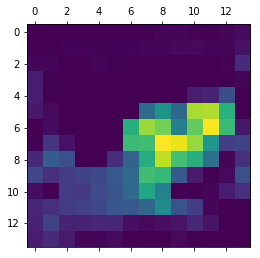

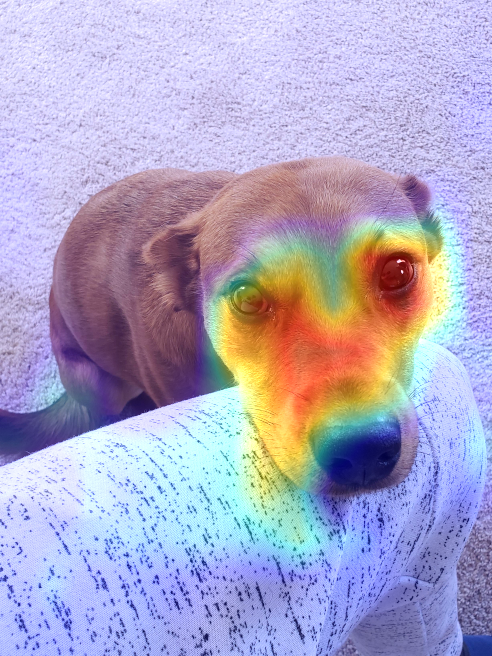

In [0]:
process_image(img_path3)

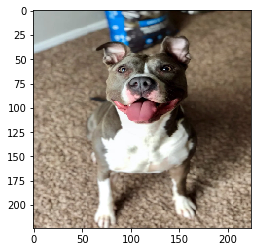

Predicted: [('n02096585', 'Boston_bull', 0.48071834), ('n02093428', 'American_Staffordshire_terrier', 0.17030458)]


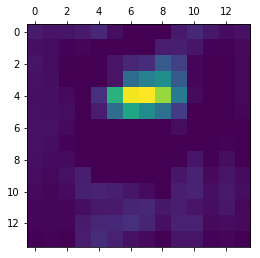

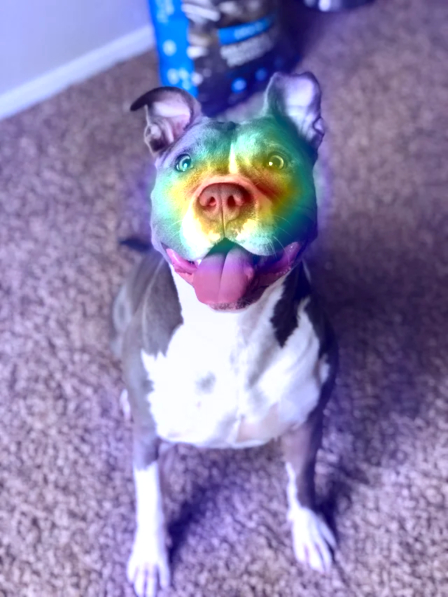

In [0]:
process_image(img_path4)